In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, glob, os
import scipy.stats as stats, scipy.io as sio
from scipy.ndimage import gaussian_filter1d
from neo.io import BlackrockIO
from nilearn import datasets, plotting

In [2]:
patient = 18

### First, get df_spikes (neur & spike times), df_trigs (event times), and df_psychopy (trial info)

### df_spikes

In [3]:
# df_spikes = final_neur_df.copy()
df_spikes = pd.read_parquet(f'../../results/2025{patient}/records/df_spikes.parquet')

eg_spikes = df_spikes['spikes'].iloc[0]
print("last 5 spikes (s):", eg_spikes[-5:])
print("last 5 spikes (min):", eg_spikes[-5:] / 60)

n_neurs = len(df_spikes)
df_spikes


last 5 spikes (s): [1641.31823333 1644.7786     1645.8907     1651.39533333 1653.17633333]
last 5 spikes (min): [27.35530389 27.41297667 27.43151167 27.52325556 27.55293889]


,chanID,clustID,spikes,#spikes,avgFR,region,x,y,z
0,193,421,"[2.9386333333333337, 3.025166666666667, 6.5640...",572,0.346617,mROFC1,5.400004,42.999992,-10.400004
1,193,467,"[3.260966666666667, 5.094733333333334, 11.0821...",1250,0.757284,mROFC1,5.400004,42.999992,-10.400004
2,200,833,"[1.5603333333333336, 3.720666666666667, 5.7518...",1301,0.788853,mROFC8,3.000004,44.199992,-10.400004
3,202,871,"[3.734466666666667, 4.718, 8.183800000000002, ...",1114,0.681801,mRACC2,6.600004,29.799992,23.199994
4,202,892,"[21.639133333333337, 25.3345, 26.2455000000000...",591,0.361751,mRACC2,6.600004,29.799992,23.199994
5,203,464,"[4.283266666666667, 6.975800000000001, 10.0429...",684,0.414428,mRACC3,6.600004,27.399993,23.199994
6,204,701,"[0.5282, 1.0729333333333335, 1.3612, 2.3284666...",1727,1.043810,mRACC4,7.800004,27.399993,23.199994
7,204,708,"[5.711866666666667, 12.2751, 13.62493333333333...",1026,0.622157,mRACC4,7.800004,27.399993,23.199994
8,205,590,"[3.493566666666667, 4.5576, 7.251833333333334,...",912,0.552273,mRACC5,7.800004,29.799992,23.199994
9,206,612,"[0.017533333333333335, 0.6868666666666667, 3.7...",951,0.576399,mRACC6,9.000004,28.599993,23.199994


plot electrode location

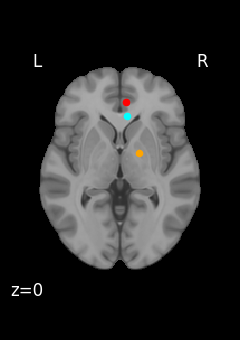

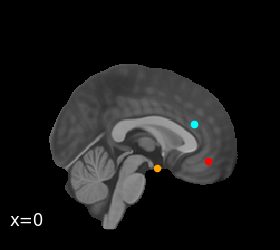

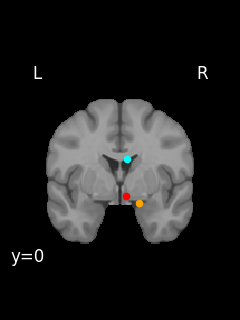

{'OFC': 'red', 'ACC': 'cyan', 'HIP': 'orange'}


In [4]:
template = datasets.load_mni152_template()

# grab most distal channels for each electrode
# IDs were different for older recording system (pt12)
if patient == 12: plot_chanIDs = [97, 105, 113]
else: plot_chanIDs = [193, 202, 210]

coords_list = []
for ch in plot_chanIDs:
    row = df_spikes[df_spikes['chanID'] == ch].iloc[0]   # first match
    coords_list.append([row.x, row.y, row.z])

coords = np.array(coords_list)

coord_regions  = ['OFC', 'ACC', 'HIP']
colors = {'OFC':'red', 'ACC':'cyan', 'HIP':'orange'}
marker_size = 20
# x = sagittal, y = coronal, z = axial

# 1. axial
# fix z (axial)
axial_cut = 0
coords_ax = coords.copy()
coords_ax[:,2] = axial_cut
disp1 = plotting.plot_anat(template, display_mode='z', cut_coords=[axial_cut],
                           cmap='gray', black_bg=True, draw_cross=False, colorbar=False)
for (x,y,z), name in zip(coords_ax, coord_regions):
    disp1.add_markers([(x,y,z)], marker_size=marker_size, marker_color=colors[name])
    
# 2. sagittal (x=0)
sag1_cut = 0
coords_sag1 = coords.copy()
coords_sag1[:,0] = sag1_cut
disp2 = plotting.plot_anat(template, display_mode='x', cut_coords=[sag1_cut],
                           cmap='gray', black_bg=True, draw_cross=False, colorbar=False)
for (x,y,z), name in zip(coords_sag1, coord_regions):
    disp2.add_markers([(x,y,z)], marker_size=marker_size, marker_color=colors[name])

# 3. coronal (y=30)
cor_cut = 0
coords_cor = coords.copy()
coords_cor[:,1] = cor_cut
disp4 = plotting.plot_anat(template, display_mode='y', cut_coords=[cor_cut],
                           cmap='gray', black_bg=True, draw_cross=False, colorbar=False)
for (x,y,z), name in zip(coords_cor, coord_regions):
    disp4.add_markers([(x,y,z)], marker_size=marker_size, marker_color=colors[name])

plotting.show()

print(colors)

### df_trigs

In [5]:
# load
nev_file = glob.glob(f'../../results/2025{patient}/raw/*.nev')[0]
io = BlackrockIO(nev_file)
seg = io.read_block(lazy=False).segments[0]
dig_ev = [ev for ev in seg.events if "digital" in ev.name.lower()][0]

# map codes to labels
code_map = {
    10: "block started",
    20: "baseline started",
    30: "stim started",
    40: "delay started",
    50: "task started",
    51: "marker moved",
    52: "left pressed",
    53: "left released",
    54: "right pressed",
    55: "right released",
    56: "response submitted",
    60: "anticipation started",
    70: "feedback started",
    80: "block ended",
}

# build df
df_trigs_raw = pd.DataFrame({
    "trigger_code": dig_ev.labels.astype(int),
    "time": dig_ev.times.magnitude
})
df_trigs_raw["event"] = df_trigs_raw["trigger_code"].map(code_map)


# find index of 1st '10' (block started)
block1_start_idx = df_trigs_raw.index[df_trigs_raw["trigger_code"] == 10][0]
# align times relative to block1 start
df_trigs_raw["rel_time"] = df_trigs_raw["time"] - df_trigs_raw.loc[block1_start_idx, "time"]
# drop triggers before block1 start
df_trigs = df_trigs_raw[block1_start_idx:]
# drop abs time
df_trigs = df_trigs.drop(columns=['time']).reset_index(drop=True)

# print last 10 times in mins
print('last 10 times in mins: ' + str(df_trigs['rel_time'][-10:].values / 60), end='\n\n')

print(df_trigs.head(10))


last 10 times in mins: [25.54153967 25.55816801 25.57959023 25.58649857 25.58650134 25.60094579
 25.60622356 25.60623912 25.61038968 25.62716246]

   trigger_code                 event   rel_time
0            10         block started   0.000000
1            20      baseline started  13.419736
2            30          stim started  14.504069
3            40         delay started  15.498836
4            50          task started  16.984470
5            51          marker moved  18.482103
6            54         right pressed  18.482236
7            55        right released  18.848803
8            56    response submitted  19.265336
9            60  anticipation started  19.266303


In [6]:
# checks
n_blocks = sum(df_trigs['event'] == 'block started')
n_stim = sum(df_trigs['event'] == 'stim started')
n_delay = sum(df_trigs['event'] == 'delay started')
n_task = sum(df_trigs['event'] == 'task started')
n_feedback = sum(df_trigs['event'] == 'feedback started')
print(n_blocks, n_stim, n_delay, n_task, n_feedback)


6 240 240 240 240


### df_psychopy

In [7]:
pts_df = pd.read_csv('../../results/psychopy/all_subjs_clean.csv')
df_psych = pts_df.loc[pts_df['subj'] == str(patient)].reset_index(drop=True)
df_psych

,dir_flip,sess_flip,chosen_pos_aligned,div_pos_aligned,stim_pos_aligned,true_class,pred_class,err_type,invalid,missed,...,Mcross.started,Mcross.stopped,Lcross.started,Rcross.started,Lcross.stopped,Rcross.stopped,Unnamed: 122,Unnamed: 115,stim_ranks,resp_ranks
0,1.0,1.0,0.108,0.0,0.38,1,1,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.5,39.0
1,0.0,1.0,-0.032,-0.0,0.14,1,0,-1,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.5,21.0
2,0.0,1.0,-0.200,-0.0,-0.06,0,0,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.5,2.5
3,0.0,1.0,-0.116,-0.0,-0.18,0,0,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.5,10.0
4,1.0,1.0,-0.116,0.0,-0.02,0,0,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.5,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.0,1.0,-0.236,-0.2,-0.38,0,0,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,10.0
236,0.0,1.0,-0.240,-0.2,-0.26,0,0,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.5,8.5
237,1.0,1.0,-0.220,-0.2,-0.22,0,0,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.5,14.0
238,0.0,1.0,-0.256,-0.2,-0.18,1,0,-1,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5,6.0


In [8]:
df_psych['uncertainty'].value_counts()
pt_base = df_psych[df_psych['condition'] == 'baseline']
pt_gain_exp = df_psych[df_psych['condition'] == 'rew_comp']
pt_loss_exp = df_psych[df_psych['condition'] == 'pen_comp']
pt_base['uncertainty'].value_counts(), pt_gain_exp['uncertainty'].value_counts(), pt_loss_exp['uncertainty'].value_counts()

(uncertainty
 False    40
 True     40
 Name: count, dtype: int64,
 uncertainty
 True     60
 False    20
 Name: count, dtype: int64,
 uncertainty
 True     60
 False    20
 Name: count, dtype: int64)

## get spikes & rates within each epoch, for every neuron & trial

In [9]:
# bin params
size, dt = .02, .001

# epoch prestarts and durations
epochs = ['baseline', 'stim', 'delay', 'task', 'feedback']
epoch_prestarts, epoch_durs = {}, {}

# plot -.25s before onset for most epochs, -1s for task (response submission), 0 for baseline
for epoch in epochs:
    if epoch == 'baseline':
        epoch_prestarts[epoch] = 0
    elif epoch == 'task':
        epoch_prestarts[epoch] = 1
    else:
        epoch_prestarts[epoch] = .25

# plot duration: 1.5 for delay, and 1s for the others, 0 for task (because we plot till onset=0 of anticipation) 
for epoch in epochs:
    if epoch == 'delay':
        epoch_durs[epoch] = 1.5
    elif epoch == 'task':
        epoch_durs[epoch] = 0
    else:
        epoch_durs[epoch] = 1

def get_normed_FRs(FRs, base_FRs):
    # 1. trial-avged baseline, (neurons, 1)
    return FRs - base_FRs.mean(axis=(0, 2), keepdims=True)
    # 2. baseline FR per trial, (trials, neurons, 1), i.e.,avg across only timebins (axis=2)
    # return FRs - base_FRs.mean(axis=2, keepdims=True)
    # 3. no norming
    # return FRs


def get_epoch_spikes_and_FRs(df_trigs, df_spikes, epoch, size=size, dt=dt):
    ''' for each trial and neuron, get spike times and smoothed FRs (Hz) in epoch window
        df_trigs: trig times 
        df_spikes: spike times per neur '''

    epoch_prestart = epoch_prestarts[epoch]
    epoch_dur = epoch_durs[epoch]

    # bin edges & centers for hists & plots
    bin_edges = np.arange(-epoch_prestart, epoch_dur + dt, dt)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2 # avg of start & epoch_dur edges
    n_bins = len(bin_edges) - 1

    # a. get 240 START times of this epoch. then STOPS = STARTS + durations.
    epoch_start_rows = df_trigs[df_trigs['event'] == f'{epoch} started'].index
    epoch_starts = df_trigs.loc[epoch_start_rows, 'rel_time'].values
    assert len(epoch_starts) == 240

    # b. since stop times of responses are variable,
    # get 240 STOP times of response, which is marked by 'anticipation started'. then STARTS = STOPS - durations (1).
    ant_start_rows = df_trigs[df_trigs['event'] == f'anticipation started'].index
    ant_starts = df_trigs.loc[ant_start_rows, 'rel_time'].values
    assert len(ant_starts) == 240

    # 3d arr for spikes_times and binned_FRs
    trial_neur_spikes = np.empty((len(epoch_starts), len(df_spikes)), dtype=object)
    trial_neur_FRs = np.zeros((len(epoch_starts), len(df_spikes), n_bins))

    # for this particular epoch, grab spikes for each trial & neur 
    for trial_idx in range(len(epoch_starts)):

        for neur_idx, (_, neur_row) in enumerate(df_spikes.iterrows()):

            spike_train = np.zeros(n_bins)

            # 1. spikes within epoch (onset-prestart => onset+duration)

            if epoch != 'task': 
                trial_epoch_spikes = neur_row['spikes'][(neur_row['spikes'] >= epoch_starts[trial_idx] - epoch_prestart) &
                                                        (neur_row['spikes'] <= epoch_starts[trial_idx] + epoch_dur)]          
                trial_epoch_spikes = trial_epoch_spikes - epoch_starts[trial_idx] # align
            
            else: # response
                trial_epoch_spikes = neur_row['spikes'][(neur_row['spikes'] >= ant_starts[trial_idx] - epoch_prestart) &
                                                        (neur_row['spikes'] <= ant_starts[trial_idx] + epoch_dur)]          
                trial_epoch_spikes = trial_epoch_spikes - ant_starts[trial_idx] # align

            # 2. FRs within epoch
            # histogram counts → Hz
            counts, _ = np.histogram(trial_epoch_spikes, bins=bin_edges)
            spike_train = counts.astype(float) / dt
            # smooth
            smooth_spike_train = gaussian_filter1d(spike_train, sigma=size/dt, mode='reflect', truncate=3.0)
            # scale FR so 1 spike ≈ 1 Hz peak
            smooth_spike_train = smooth_spike_train / 20.0
            # finally, store
            trial_neur_spikes[trial_idx, neur_idx] = trial_epoch_spikes
            trial_neur_FRs[trial_idx, neur_idx, :] = smooth_spike_train

    return trial_neur_spikes, trial_neur_FRs, bin_centers


### plot baseline spikes and FRs for random neuron on random trials

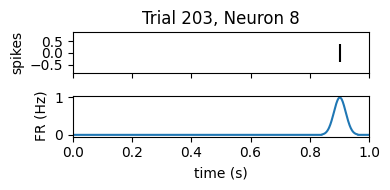

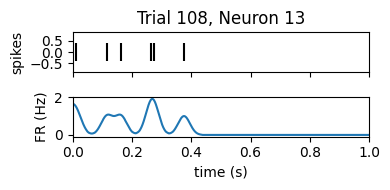

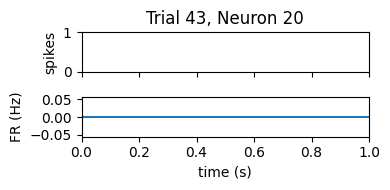

In [29]:
# baseline spikes/FRs for norming
base_spikes, base_FRs, bin_centers = get_epoch_spikes_and_FRs(df_trigs, df_spikes, 'baseline')

n_trials, n_neurs = base_spikes.shape[:2]

for _ in range(3):
    trial_idx = np.random.randint(0, n_trials)
    neur_idx  = np.random.randint(0, n_neurs)

    spikes = base_spikes[trial_idx, neur_idx]
    fr     = base_FRs[trial_idx, neur_idx]

    fig, ax = plt.subplots(2, 1, figsize=(4,2), sharex=True)

    ax[0].eventplot(spikes, colors='black', lineoffsets=0, linelengths=0.8)
    ax[0].set_ylabel("spikes")
    ax[0].set_title(f"Trial {trial_idx}, Neuron {neur_idx}")

    ax[1].plot(bin_centers, fr)
    ax[1].set_ylabel("FR (Hz)")
    ax[1].set_xlabel("time (s)")
    ax[1].set_xlim(0, 1)   # explicitly enforce 0–1 for baseline

    plt.tight_layout()
    plt.show()


### rasters + psth for all neurons

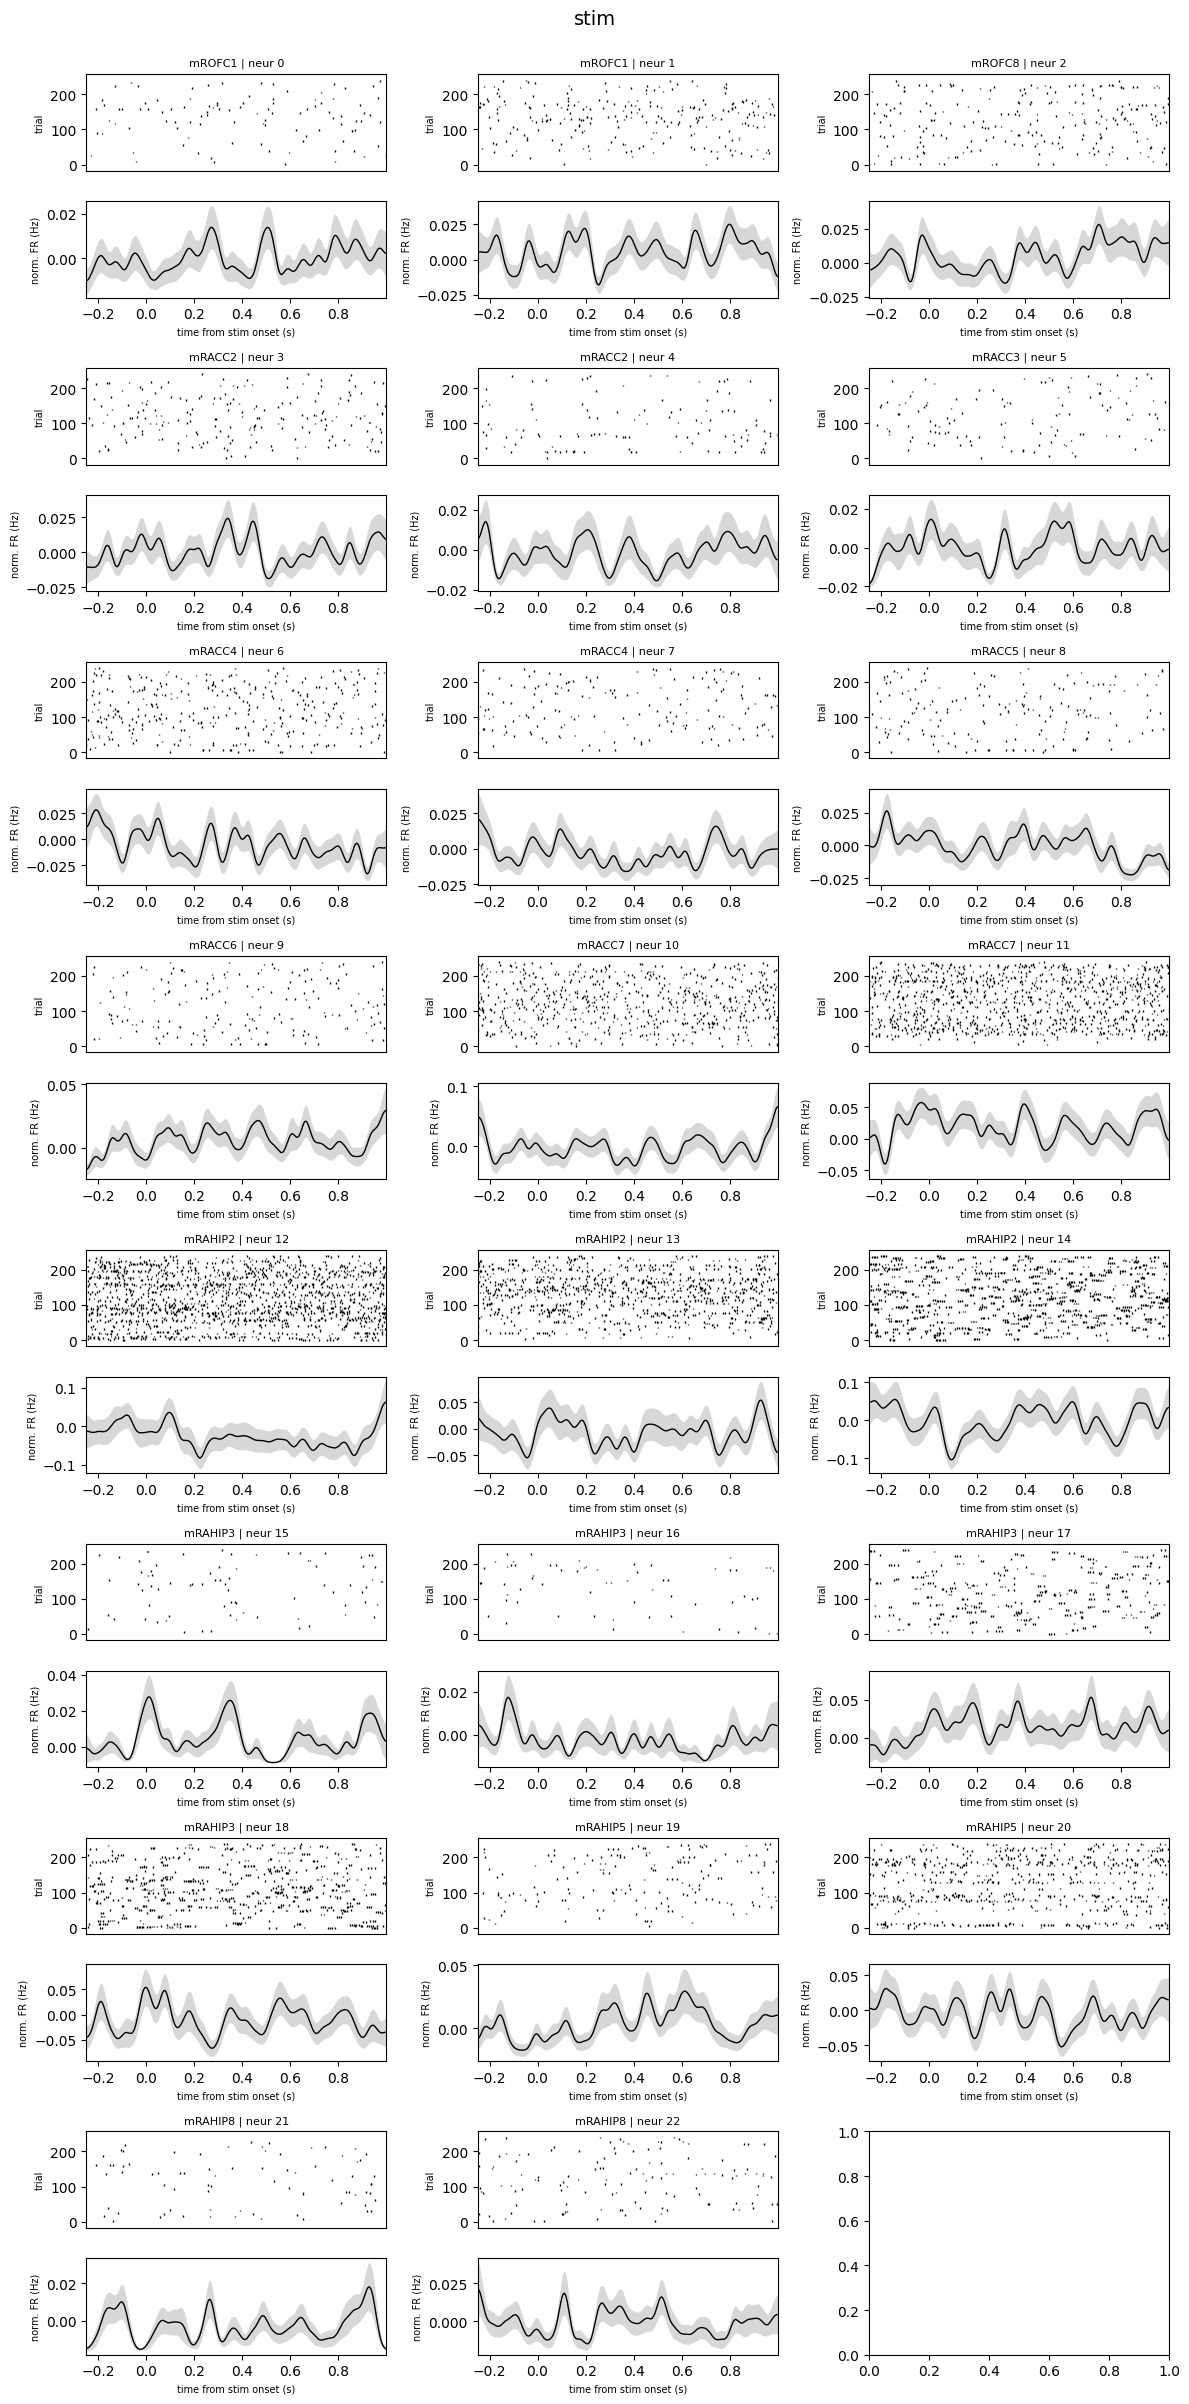

In [33]:
norm, epoch = True, 'stim'
spikes, FRs, bin_centers = get_epoch_spikes_and_FRs(df_trigs, df_spikes, epoch, size, dt)

# choose whether to normalize, and accordingly label y-axis
if norm: normed_FRs, yaxis_lab = get_normed_FRs(FRs, base_FRs), 'norm. '
else: normed_FRs, yaxis_lab = FRs.copy(), ''

n_trials, n_neurs = FRs.shape[0], FRs.shape[1]

# ----- common FR y-axis (use normed for non-baseline, raw for baseline) -----
# FR_all = normed_FRs if epoch != 'baseline' else FRs
# ymin = max(0, np.percentile(FR_all, 1))
# ymax = np.percentile(FR_all, 99)

# ----- grid of neurons -----
n_cols = 3
n_rows = int(np.ceil(n_neurs / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axs = axs.flatten()

ax_idx = 0
for neur_id in range(n_neurs):
    if ax_idx >= len(axs):
        break

    # placeholder axes -> we’ll replace with 2 stacked axes
    ax_main = axs[ax_idx]
    ss = ax_main.get_subplotspec()
    ax_main.remove()

    gs = ss.subgridspec(2, 1, height_ratios=[1, 1])
    ax_raster = fig.add_subplot(gs[0])
    ax_psth   = fig.add_subplot(gs[1], sharex=ax_raster)

    # --------- RASTER ---------
    ax_raster.eventplot(
        spikes[:, neur_id],
        colors='k',
        lineoffsets=np.arange(n_trials),
        linelengths=5.0,
        linewidths=1.0
    )
    region = df_spikes["region"].iloc[neur_id]
    ax_raster.set_title(f"{region} | neur {neur_id}", fontsize=8)
    ax_raster.set_ylabel("trial", fontsize=7)
    ax_raster.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

    # --------- PSTH ---------
    data = normed_FRs[:, neur_id, :] if epoch != 'baseline' else FRs[:, neur_id, :]
    mu = data.mean(axis=0)
    sderr = data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])

    ax_psth.plot(bin_centers, mu, color='k', linewidth=1)
    ax_psth.fill_between(bin_centers, mu - sderr, mu + sderr,
                         color='0.7', alpha=0.5, linewidth=0)

    ax_psth.set_xlim(bin_centers[0], bin_centers[-1])
    ax_psth.set_ylabel(f"{yaxis_lab}FR (Hz)", fontsize=7)
    ax_psth.set_xlabel(f"time from {epoch} onset (s)", fontsize=7)

    ax_idx += 1

plt.suptitle(epoch, y=1.0, fontsize=14)
plt.tight_layout()
plt.show()


## create contrasts

In [34]:
def get_contrast_in_epoch(df_trigs, df_spikes, subj_df, epoch, contrast):
    ''' for particular contrast, in a particular epoch, draw out spikes & FRs
        df_trigs: trig times
        df_spikes: spike times
        subj_df: trial info '''
    
    print(f'contrast: {contrast}, epoch: {epoch}')

    # get spikes/FRs for all trials/neurons in this epoch
    spikes, FRs, bin_centers = get_epoch_spikes_and_FRs(df_trigs, df_spikes, epoch, size, dt)

    # spikes, FRs, bin_centers = get_trial_spikes_and_FRs(df_trigs, df_spikes, 'first_half', size, dt)
    # spikes, FRs, bin_centers = get_trial_spikes_and_FRs(df_trigs, df_spikes, 'second_half', size, dt)

    # storing trials and labels for each contrast
    cont_trials, cont_labels = [], []

    # stim contrasts
    if contrast =='context':
        cont_trials.append(subj_df[subj_df['stim_pos_aligned'] > subj_df['div_pos_aligned']].index)
        cont_trials.append(subj_df[subj_df['stim_pos_aligned'] < subj_df['div_pos_aligned']].index)
        cont_labels.append('gain')
        cont_labels.append('loss')
    # elif contrast =='stim':
    #     cont_trials.append(subj_df[subj_df['stim_pos_aligned'] > .0].index)
    #     cont_trials.append(subj_df[subj_df['stim_pos_aligned'] < -.0].index)
    #     cont_labels.append('flat (curv) stims')
    #     cont_labels.append('curv (flat) stims')
    elif contrast =='uncertainty':
        cont_trials.append(subj_df[~subj_df['uncertainty']].index)
        cont_trials.append(subj_df[subj_df['uncertainty']].index)
        cont_labels.append('certain')
        cont_labels.append('uncertain')

    # choice contrasts (median splits)
    elif contrast == 'resp_dir':
        cont_trials.append(subj_df[subj_df['chosen_pos'] > subj_df['div_pos']].index)
        cont_trials.append(subj_df[subj_df['chosen_pos'] < subj_df['div_pos']].index)
        cont_labels.append('right')
        cont_labels.append('left')
    elif contrast == 'normed_RT':
        median_rt = subj_df['normed_RT'].median()
        cont_trials.append(subj_df[subj_df['normed_RT'] <= median_rt].index)
        cont_trials.append(subj_df[subj_df['normed_RT'] > median_rt].index)
        cont_labels.append('fast')
        cont_labels.append('slow')
    # elif contrast == 'dir_flip':
    #     cont_trials.append(subj_df[subj_df['dir_flip'] == 0].index)
    #     cont_trials.append(subj_df[subj_df['dir_flip'] == 1].index)
    #     cont_labels.append('not flipped')
    #     cont_labels.append('flipped')


    # outcome contrasts
    elif contrast == 'outcome':
        cont_trials.append(subj_df[subj_df['outcome'] == 3].index)
        cont_trials.append(subj_df[subj_df['outcome'] == 1].index)
        cont_trials.append(subj_df[subj_df['outcome'] == -1].index)
        cont_trials.append(subj_df[subj_df['outcome'] == -3].index)
        cont_labels.append('3 coins')
        cont_labels.append('1 coin')
        cont_labels.append('-1 coin')
        cont_labels.append('-3 coins')

    # condition contrast
    elif contrast == 'conditions':
        cont_trials.append(subj_df[subj_df['condition'] == 'pen_comp'].index)
        cont_trials.append(subj_df[subj_df['condition'] == 'rew_comp'].index)
        cont_trials.append(subj_df[subj_df['condition'] == 'baseline'].index)
        cont_labels.append('gain_expanded')
        cont_labels.append('loss_expanded')
        cont_labels.append('baseline')
    elif contrast == 'baseline vs compressed conditions':
        cont_trials.append(subj_df[subj_df['condition'] != 'baseline'].index)
        cont_trials.append(subj_df[subj_df['condition'] == 'baseline'].index)
        cont_labels.append('comp')
        cont_labels.append('base')

    # err
    else:
        raise ValueError('Invalid contrast')

    print('#trials should typically be 240/#contrasts')

    print('spikes (#trials, #neurs)')
    for contrast_idx in range(len(cont_labels)):
        print(f'\t{cont_labels[contrast_idx]}: {spikes[cont_trials[contrast_idx], :].shape}')
    
    print('rates (#trials, #neurs, #bins)')
    for contrast_idx in range(len(cont_labels)):
        print(f'\t{cont_labels[contrast_idx]}: {FRs[cont_trials[contrast_idx], :, :].shape}')

    return spikes, FRs, bin_centers, cont_trials, cont_labels


### contrasted rasters + psth for all neurons

contrast: context, epoch: stim
#trials should typically be 240/#contrasts
spikes (#trials, #neurs)
	gain: (120, 23)
	loss: (120, 23)
rates (#trials, #neurs, #bins)
	gain: (120, 23, 1250)
	loss: (120, 23, 1250)


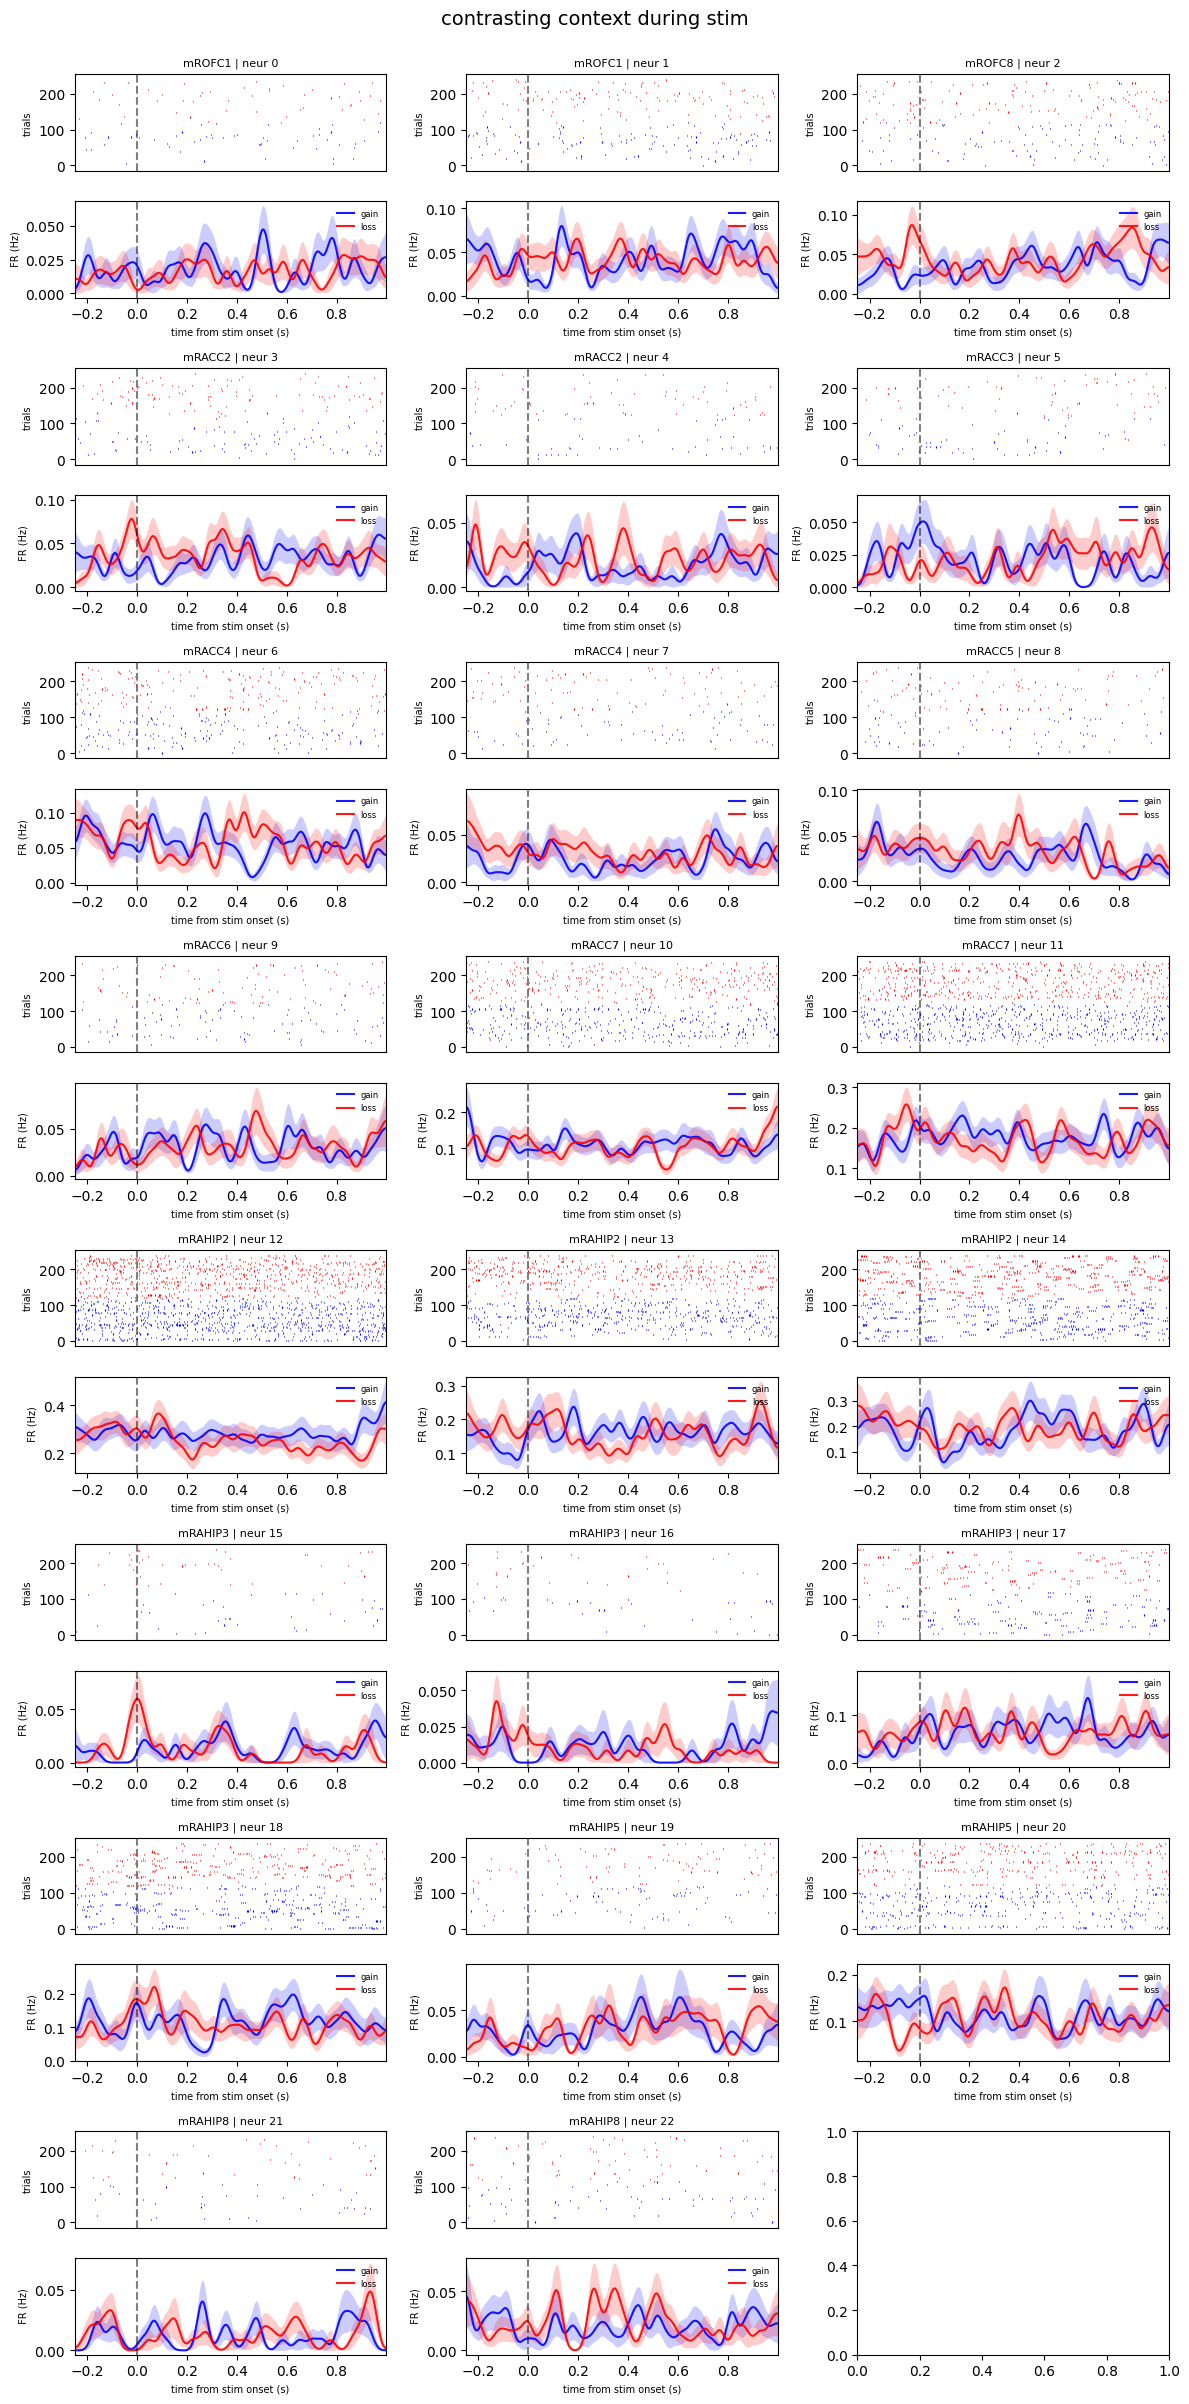

In [35]:
norm, epoch, contrast = False, 'stim', 'context'
spikes, FRs, bin_centers, cont_trials, cont_labels = get_contrast_in_epoch(
    df_trigs, df_spikes, df_psych, epoch, contrast
)

# choose whether to normalize, and accordingly label y-axis
if norm: normed_FRs, yaxis_lab = get_normed_FRs(FRs, base_FRs), 'norm. '
else: normed_FRs, yaxis_lab = FRs.copy(), ''

n_trials, n_neurs, _ = FRs.shape
colors = ['b', 'r', 'g', 'k']  # assume len(cont_labels) <= 4

# ---- grid of neurons ----
n_cols = 3
n_rows = int(np.ceil(n_neurs / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axs = axs.flatten()

ax_idx = 0
for neur_id in range(n_neurs):
    if ax_idx >= len(axs):
        break

    # take the placeholder axis for this neuron, then replace with 2 stacked axes
    ax_main = axs[ax_idx]
    ss = ax_main.get_subplotspec()
    ax_main.remove()

    gs = ss.subgridspec(2, 1, height_ratios=[1, 1])
    ax_raster = fig.add_subplot(gs[0])
    ax_psth   = fig.add_subplot(gs[1], sharex=ax_raster)

    # -----------------
    # 1. RASTER (top)
    # -----------------
    raster_trial_list, color_trial_list = [], []

    for idx in range(len(cont_labels)):
        cont_label = cont_labels[idx]
        trial_idx_list = cont_trials[idx]
        cont_color = colors[idx]

        # spikes[trial_idx_list, neur_id] is an array of per-trial spike arrays
        raster_trial_list.extend(list(spikes[trial_idx_list, neur_id]))
        color_trial_list.extend([cont_color] * len(trial_idx_list))

    ax_raster.axvline(0, color='k', linestyle='--', alpha=0.5)
    ax_raster.eventplot(raster_trial_list,orientation='horizontal',colors=color_trial_list,linewidths=0.8,linelengths=3.0,)

    region = df_spikes["region"].iloc[neur_id]
    ax_raster.set_title(f"{region} | neur {neur_id}", fontsize=8)
    ax_raster.set_ylabel("trials", fontsize=7)
    ax_raster.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

    # -----------------
    # 2. PSTH (bottom)
    # -----------------
    for idx in range(len(cont_labels)):
    # for this contrast

        cont_label = cont_labels[idx]
        cont_color = colors[idx]
        cont_data = normed_FRs[cont_trials[idx], neur_id, :]
        
        # for plotting
        mu = cont_data.mean(axis=0)
        sderr = (cont_data.std(axis=0, ddof=1) / np.sqrt(cont_data.shape[0])
                 if cont_data.shape[0] > 1 else np.zeros_like(mu))
        ax_psth.plot(bin_centers, mu, color=cont_color, alpha=0.9, label=cont_label)
        ax_psth.fill_between(bin_centers, mu - sderr, mu + sderr,
                             color=cont_color, alpha=0.2, linewidth=0)

    ax_psth.axvline(0, color='k', linestyle='--', alpha=0.5)
    ax_psth.set_xlim(bin_centers[0], bin_centers[-1])
    ax_psth.set_ylabel(f"{yaxis_lab} FR (Hz)", fontsize=7)
    ax_psth.set_xlabel(f"time from {epoch} onset (s)", fontsize=7)

    # small legend per neuron (optional — you can drop this if too cluttered)
    ax_psth.legend(loc='upper right', fontsize=6, frameon=False)

    ax_idx += 1

plt.suptitle(f"contrasting {contrast} during {epoch}", y=1.0, fontsize=14)
plt.tight_layout()
plt.show()


### single neuron

In [14]:
# # get unique rowID where region = 'mLACC5'. there might be multiple
# reg = 'mLACC5'
# neur_id = neur_spikes_df[neur_spikes_df['region'] == reg].index[0]

# # 1. raster
# plt.figure(figsize=(4,3))
# plt.title(f'{neur_spikes_df["region"].iloc[neur_id]} neuron')

# # 1. raster
# # create list of trials by contrast and corresponding color
# raster_trial_list, color_trial_list = [], []
# # for indx in range(len(cont_labels)):
# for indx in [1,0]:
#     cont_label, cont_trial, cont_color = cont_labels[indx], cont_trials[indx], colors[indx]
#     raster_trial_list.extend(list(spikes[cont_trial, neur_id]))
#     color_trial_list.extend([cont_color] * len(cont_trial))

# plt.axvline(0, color='k', linestyle='--', alpha=0.5)
# plt.eventplot(raster_trial_list, orientation='horizontal', colors=color_trial_list, linewidths=1.0, linelengths=3.0)
# plt.ylabel('sorted trials')
# plt.xlabel(f'time from\n{phase} onset (s)')
# plt.xlim([phase_prestarts[phase], phase_ends[phase]])
# plt.show()

# # 2. psth
# plt.figure(figsize=(4,3))

# for indx in range(len(cont_labels)):
#     cont_label, cont_trial, cont_color = cont_labels[indx], cont_trials[indx], colors[indx]

#     data = normed_FRs[cont_trial, neur_id, :]
#     mu = data.mean(axis=0)
#     sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
#     plt.plot(bin_centers, mu, color=cont_color, alpha=0.9, label=cont_label)
#     plt.axvline(0, color='k', linestyle='--', alpha=0.5)
#     plt.fill_between(bin_centers, mu - sderr, mu + sderr, color=cont_color, alpha=0.2, linewidth=0)

# plt.ylabel('normed FR (Hz)')
# plt.xlabel(f'time from\n{phase} onset (s)')
# plt.xlim([phase_prestarts[phase], phase_ends[phase]])
# plt.ylim([.25, 1.75])
# plt.legend(handles=[plt.Line2D([0], [0], color=colors[idx], lw=2, label=cont_labels[idx])
#                     for idx in range(len(cont_labels))], loc='upper right')
# plt.show()


### rasters & psth separately

epoch rasters

In [15]:
# epoch = 'baseline'
# spikes, FRs, bin_centers = get_epoch_spikes_and_FRs(df_trigs, df_spikes, epoch, size, dt)
# normed_FRs = get_normed_FRs(FRs, base_FRs)

# n_rows, n_cols = int(np.ceil(n_neurs/3)), 3
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*2))
# axs, ax = axs.flatten(), 0

# for neur_id in range(n_neurs):
#     axs[ax].eventplot(spikes[:, neur_id], orientation='horizontal', colors='k', alpha=0.3, linewidths=1., linelengths=3.)
#     axs[ax].set(title=f'{neur_spikes_df["region"].iloc[neur_id]} neuron, id={neur_id}',
#                 ylabel='trial', xlabel=f'time from {epoch} onset (s)', xlim=[epoch_prestarts[epoch], epoch_durs[epoch]])
#     ax += 1

# plt.suptitle(epoch, y=1.0, fontsize=16)
# plt.tight_layout()
# plt.show()


epoch psth

In [16]:
# epoch = 'baseline'
# spikes, FRs, bin_centers = get_epoch_spikes_and_FRs(df_trigs, df_spikes, epoch, size, dt)
# normed_FRs = get_normed_FRs(FRs, base_FRs)

# n_rows, n_cols = int(np.ceil(n_neurs/3)), 3
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*2))
# axs, ax = axs.flatten(), 0

# for neur_i in range(n_neurs):

#     # no norming for baseline itself; otherwise norm by trial-baseline
#     data = normed_FRs[:, neur_i, :] if epoch!='baseline' else FRs[:, neur_i, :]
    
#     # grab trial-mean and sderr
#     mu = data.mean(axis=0)
#     sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
#     axs[ax].plot(bin_centers, mu, alpha=0.9)
#     axs[ax].fill_between(bin_centers, mu - sderr, mu + sderr, alpha=0.2, linewidth=0)
    
#     # axs[ax].axvline(0, color='k', linestyle='--', alpha=0.5)
#     axs[ax].set(title=f'{neur_spikes_df["region"].iloc[neur_i]} neuron', ylabel='normed FR (Hz)', xlabel=f'time from {epoch} onset (s)',
#                 xticks=np.linspace(epoch_prestarts[epoch], epoch_durs[epoch], 6), xlim=[epoch_prestarts[epoch], epoch_durs[epoch]])
#     if epoch!='baseline': axs[ax].set(ylim=[0, 2])
#     ax += 1

# plt.suptitle(epoch, y=1.0, fontsize=16)
# plt.tight_layout()
# plt.show()


contrast psth

In [17]:
# # epochs = ['baseline', 'stim', 'task', 'delay', 'feedback']
# # contrasts = ['context', 'stim', 'difficulty', 'outcome', 'conditions', 'baseline vs compressed conditions']
# epoch, contrast = 'stim', 'context'
# spikes, FRs, bin_centers, cont_trials, cont_labels = get_contrast_in_epoch(df_trigs, df_spikes, df_psych, epoch, contrast)
# normed_FRs = get_normed_FRs(FRs, base_FRs)

# n_rows, n_cols = int(np.ceil(n_neurs / 3)), 3
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*2))
# axs, ax = axs.flatten(), 0
# colors = ['b', 'r', 'g', 'k']

# for neur_id in range(n_neurs):

#     for idx in range(len(cont_labels)):

#         cont_label, cont_trial, cont_color = cont_labels[idx], cont_trials[idx], colors[idx]

#         data = normed_FRs[cont_trial, neur_id, :]

#         mu = data.mean(axis=0)
#         sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
#         axs[ax].plot(bin_centers, mu, color=cont_color, alpha=0.9, label=cont_label)
#         axs[ax].fill_between(bin_centers, mu - sderr, mu + sderr, color=cont_color, alpha=0.2, linewidth=0)

#     # axs[ax].axvline(0, color='k', linestyle='--', alpha=0.5)
#     axs[ax].set(title=f'{neur_spikes_df["region"].iloc[neur_id]} neuron', ylabel='normed FR (Hz)', xlabel=f'time from {epoch} onset (s)',
#                 xticks=np.linspace(epoch_prestarts[epoch], epoch_durs[epoch], 6), xlim=[epoch_prestarts[epoch], epoch_durs[epoch]])#, ylim=[0, 2])
#     axs[ax].legend(loc='upper right')
#     ax += 1

# plt.suptitle(epoch, y=1.01, fontsize=16)
# plt.tight_layout()
# plt.show()


### for purposes of plotting entire trial (not divided into epochs), but split into onset-aligned and outcome-aligned

In [18]:
# def get_contrast_in_trial(clean_trigs_df, final_neur_df, subj_df, trial_half, contrast):
#     ''' for particular contrast, in a particular phase, draw out spikes & FRs
#         clean_trigs_df: trig times
#         final_neur_df: spike times
#         subj_df: trial info '''
    
#     print(f'contrast: {contrast}, trial_half: {trial_half}')

#     # get spikes/FRs for all trials/neurons in this trial_half
#     spikes, FRs, bin_centers = get_trial_spikes_and_FRs(clean_trigs_df, final_neur_df, trial_half, size, dt)

#     # storing trials and labels for each contrast
#     cont_trials, cont_labels = [], []

#     # stim contrasts
#     if contrast =='context':
#         cont_trials.append(subj_df[subj_df['stim_pos_aligned'] > subj_df['div_pos_aligned']].index)
#         cont_trials.append(subj_df[subj_df['stim_pos_aligned'] < subj_df['div_pos_aligned']].index)
#         cont_labels.append('gain')
#         cont_labels.append('loss')
#     # elif contrast =='stim':
#     #     cont_trials.append(subj_df[subj_df['stim_pos_aligned'] > .0].index)
#     #     cont_trials.append(subj_df[subj_df['stim_pos_aligned'] < -.0].index)
#     #     cont_labels.append('flat (curv) stims')
#     #     cont_labels.append('curv (flat) stims')
#     elif contrast =='difficulty':
#         cont_trials.append(subj_df[~subj_df['difficulty']].index)
#         cont_trials.append(subj_df[subj_df['difficulty']].index)
#         cont_labels.append('easy')
#         cont_labels.append('hard')

#     # choice contrasts (median splits)
#     elif contrast == 'resp_dir':
#         cont_trials.append(subj_df[subj_df['chosen_pos'] > subj_df['div_pos']].index)
#         cont_trials.append(subj_df[subj_df['chosen_pos'] < subj_df['div_pos']].index)
#         cont_labels.append('right')
#         cont_labels.append('left')
#     elif contrast == 'normed_RT':
#         median_rt = subj_df['normed_RT'].median()
#         cont_trials.append(subj_df[subj_df['normed_RT'] <= median_rt].index)
#         cont_trials.append(subj_df[subj_df['normed_RT'] > median_rt].index)
#         cont_labels.append('fast')
#         cont_labels.append('slow')
#     # elif contrast == 'dir_flip':
#     #     cont_trials.append(subj_df[subj_df['dir_flip'] == 0].index)
#     #     cont_trials.append(subj_df[subj_df['dir_flip'] == 1].index)
#     #     cont_labels.append('not flipped')
#     #     cont_labels.append('flipped')


#     # outcome contrasts
#     elif contrast == 'outcome':
#         cont_trials.append(subj_df[subj_df['outcome'] == 3].index)
#         cont_trials.append(subj_df[subj_df['outcome'] == 1].index)
#         cont_trials.append(subj_df[subj_df['outcome'] == -1].index)
#         cont_trials.append(subj_df[subj_df['outcome'] == -3].index)
#         cont_labels.append('3 coins')
#         cont_labels.append('1 coin')
#         cont_labels.append('-1 coin')
#         cont_labels.append('-3 coins')

#     # condition contrast
#     elif contrast == 'conditions':
#         cont_trials.append(subj_df[subj_df['condition'] == 'pen_comp'].index)
#         cont_trials.append(subj_df[subj_df['condition'] == 'rew_comp'].index)
#         cont_trials.append(subj_df[subj_df['condition'] == 'baseline'].index)
#         cont_labels.append('gain_expanded')
#         cont_labels.append('loss_expanded')
#         cont_labels.append('baseline')
#     elif contrast == 'baseline vs compressed conditions':
#         cont_trials.append(subj_df[subj_df['condition'] != 'baseline'].index)
#         cont_trials.append(subj_df[subj_df['condition'] == 'baseline'].index)
#         cont_labels.append('comp')
#         cont_labels.append('base')

#     # err
#     else:
#         raise ValueError('Invalid contrast')

#     print('#trials should typically be 240/#contrasts')

#     print('spikes (#trials, #neurs)')
#     for contrast_idx in range(len(cont_labels)):
#         print(f'\t{cont_labels[contrast_idx]}: {spikes[cont_trials[contrast_idx], :].shape}')
    
#     print('rates (#trials, #neurs, #bins)')
#     for contrast_idx in range(len(cont_labels)):
#         print(f'\t{cont_labels[contrast_idx]}: {FRs[cont_trials[contrast_idx], :, :].shape}')

#     return spikes, FRs, bin_centers, cont_trials, cont_labels


In [19]:
# # phases = ['baseline', 'stim', 'task', 'delay', 'feedback']
# # contrasts = ['context', 'stim', 'difficulty', 'outcome', 'conditions', 'baseline vs compressed conditions']
# trial_half, contrast = '2nd', 'context'
# spikes, FRs, bin_centers, cont_trials, cont_labels = get_contrast_in_trial(clean_trigs_df, final_neur_df, subj_df, trial_half, contrast)
# normed_FRs = get_normed_FRs(FRs, base_FRs)

In [20]:
# # get unique rowID where region = 'mLACC5'. there might be multiple
# reg = 'mLACC5'
# neur_id = neur_spikes_df[neur_spikes_df['region'] == reg].index[0]
# colors = ['b', 'r', 'g', 'k']

# # create figure with two subplots (stacked vertically)
# width = 10 if trial_half == '1st' else 6
# fig, axs = plt.subplots(2, 1, figsize=(width, 6), sharex=True,
#                         gridspec_kw={'height_ratios': [1, 1]})  # equal height

# # ---------------------------------------------
# # 1. RASTER
# # ---------------------------------------------
# # --- Raster as dots instead of lines ---
# ax = axs[0]

# trial_counter = 0
# for indx in [1, 0]:
#     cont_label, cont_trial, cont_color = cont_labels[indx], cont_trials[indx], colors[indx]
    
#     for t_i, trial_idx in enumerate(cont_trial):
#         spike_times = spikes[trial_idx, neur_id]
#         ax.scatter(spike_times, 
#                    np.ones_like(spike_times)*trial_counter, 
#                    s=4, color=cont_color, alpha=.8)  # s = marker size
#         trial_counter += 1

# ax.axvline(0, color='k', linestyle='--', alpha=0.5)
# ax.set_ylabel('sorted trials')
# if trial_half == '1st': ax.set_title('Aligned to stimulus')
# elif trial_half == '2nd': ax.set_title('Aligned to outcome')

# # ---------------------------------------------
# # 2. PSTH
# # ---------------------------------------------
# ax = axs[1]
# for indx in range(len(cont_labels)):
#     cont_label, cont_trial, cont_color = cont_labels[indx], cont_trials[indx], colors[indx]

#     data = normed_FRs[cont_trial, neur_id, :]
#     mu = data.mean(axis=0)
#     sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
#     ax.plot(bin_centers, mu, color=cont_color, alpha=0.9, label=cont_label)
#     ax.fill_between(bin_centers, mu - sderr, mu + sderr, color=cont_color, alpha=0.2, linewidth=0)

# ax.axvline(0, color='k', linestyle='--', alpha=0.5)
# ax.set_ylabel('normed FR (Hz)')
# ax.set_ylim([0, 1.75])

# # ax.set_xlabel(f'time from {phase} onset (s)')
# if trial_half == '1st':
#     ax.set_xlim([-.25, 3.5])
#     for ax in axs:
#         ax.axvline(1, color='k', linestyle='--', alpha=0.5) # end of response
#         ax.axvline(2.5, color='k', linestyle='--', alpha=0.5) # end of response
# elif trial_half == '2nd':
#     ax.set_xlim([-1.25, 1])
#     for ax in axs:
#         ax.axvline(-.25, color='k', linestyle='--', alpha=0.5) # end of response

# # legend
# handles = [plt.Line2D([0], [0], color=colors[idx], lw=2, label=cont_labels[idx])
#             for idx in range(len(cont_labels))]
# ax.legend(handles=handles, loc='lower right')

# for ax in axs:
#     ax.tick_params(direction='in', length=4, width=1)
# for ax in axs:
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)

# plt.tight_layout()
# plt.show()
# # fig.savefig('../../results/figs/sfn/fig4a_real_neur.eps', format='eps', dpi=300)
# plt.rcParams['svg.fonttype'] = 'none'  # keeps text editable
# fig.savefig(f'../../results/figs/sfn/fig4a_trial_{trial_half}_half.svg', format='svg', dpi=300)



zifest

In [21]:
# plt.rcParams.update({
#     "axes.titlesize": 20,   # subplot titles
#     "axes.labelsize": 18,   # x/y labels
#     "xtick.labelsize": 16,  # x ticks
#     "ytick.labelsize": 16,  # y ticks
#     "legend.title_fontsize": 16,  # legend title
#     "legend.fontsize": 16,        # legend labels
# })